<a href="https://colab.research.google.com/github/yuchun-nii/DP_test/blob/main/vgg16pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
from keras import models
import skimage.io
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
#印出tensor的形狀、最大最小值
def tensor_summary(tensor):
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

#Takes a tensor of 3 dimensions (height, width, colors)
#將值normalize到[0,1]
def normalize(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def display_img(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
#images: A list of images.(圖片列表)
#ndarray:Numpy數組的列表,每個數組代表一個圖像。
#concatenate array(images):Numpy數組列表的列表(清單)。在這種情況下，內部列表中的圖像將合併為一張圖像。
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    #用zip同時迭代images跟titles，每個元素以一對一的方式配對起來/zip對不同長度的以短的為準
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")#關閉軸

        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

def read_layer(model, x, layer_name):
    #返回指定層激活值
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]

#輸出特定層的權重跟捲積出的圖片    
def view_layer(model, x, layer_name, cols=5):
    print(layer_name)
    outputs = read_layer(model, x, layer_name)
    display_img([outputs[:,:,i] for i in range(20)], cols=cols)
    plt.show()

In [3]:
model = vgg16.VGG16(weights='imagenet')#載入Keras預訓練好的權重
model.summary()#顯示模型結構，主要是用來確認layer的名稱，方便之後看feature map的時候用

553467904/553467096 [==============================] - 19s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

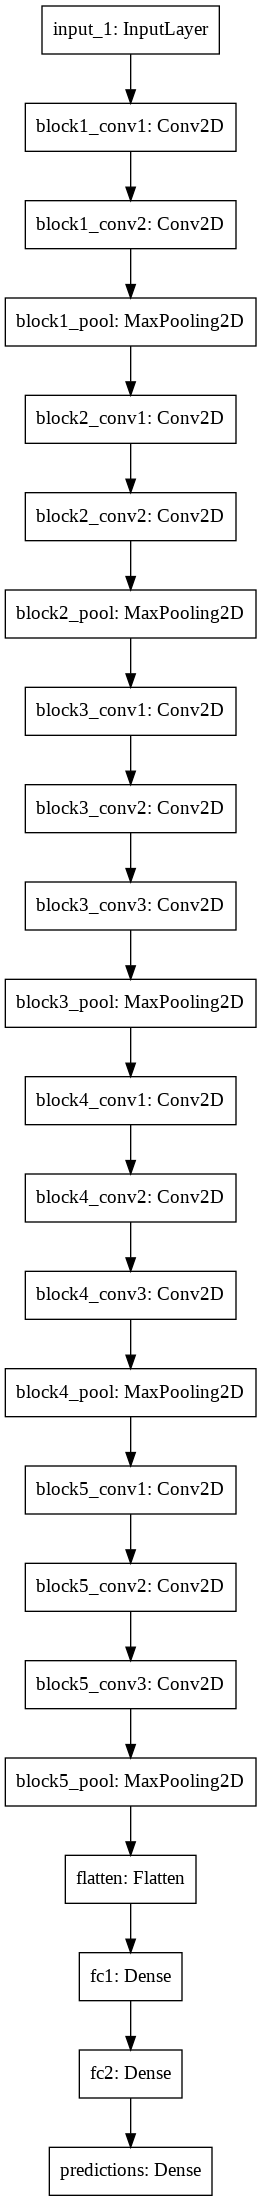

In [4]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

shape: (224, 224, 3)  min: 5  max: 255


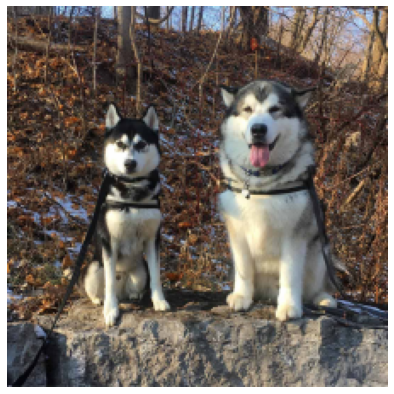

In [5]:
dim=224
#image = skimage.io.imread("http://lorempixel.com/224/224/animals/")# 從網路隨機挑一個224x224的圖片來測試模型
image=skimage.io.imread("husky3.jpg")
image = cv2.resize(image, (dim, dim), interpolation=cv2.INTER_AREA)
tensor_summary(image)
display_img([image], cols=2)

In [6]:
x = image.astype(np.float32)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
tensor_summary(x)

shape: (1, 224, 224, 3)  min: -116.68000030517578  max: 151.06100463867188


shape: (3, 3, 3, 64)  min: -0.6714000701904297  max: 0.6085159182548523


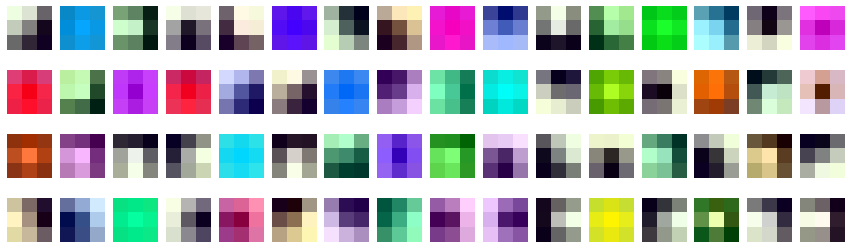

In [7]:
weights = model.get_layer("block1_conv1").get_weights()[0]
tensor_summary(weights)
display_img([weights[:,:,::-1,i] for i in range(weights.shape[3])], cols=16, interpolation="none")
plt.show()

block1_conv1
shape: (1, 224, 224, 64)  min: 0.0  max: 676.1041259765625


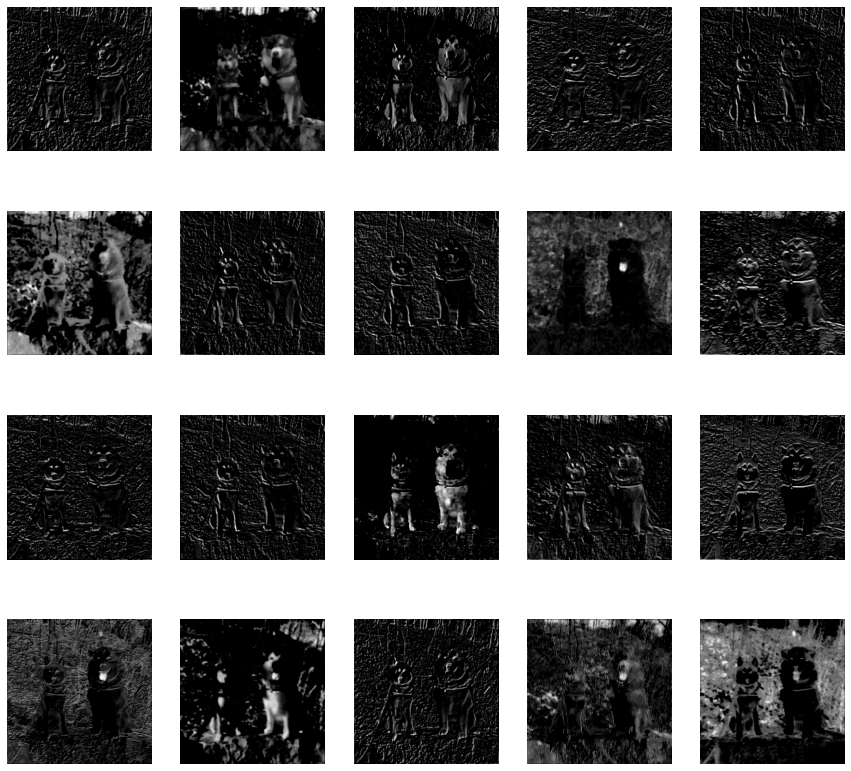

In [8]:
view_layer(model, x, "block1_conv1")

block2_conv1
shape: (1, 112, 112, 128)  min: 0.0  max: 4251.1103515625


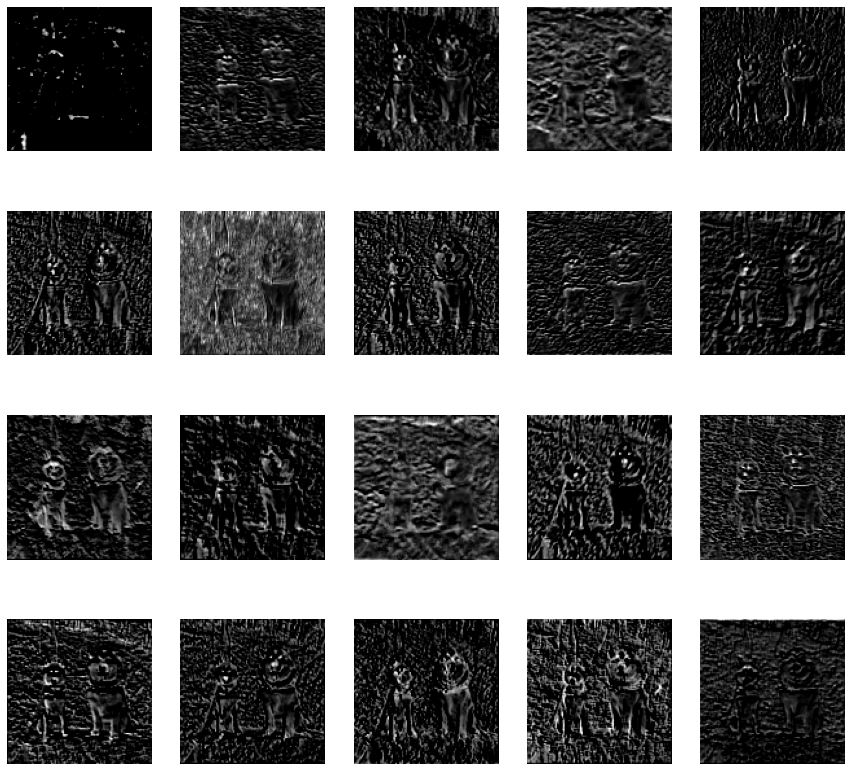

In [9]:
view_layer(model, x, "block2_conv1")

block3_conv1
shape: (1, 56, 56, 256)  min: 0.0  max: 9868.501953125


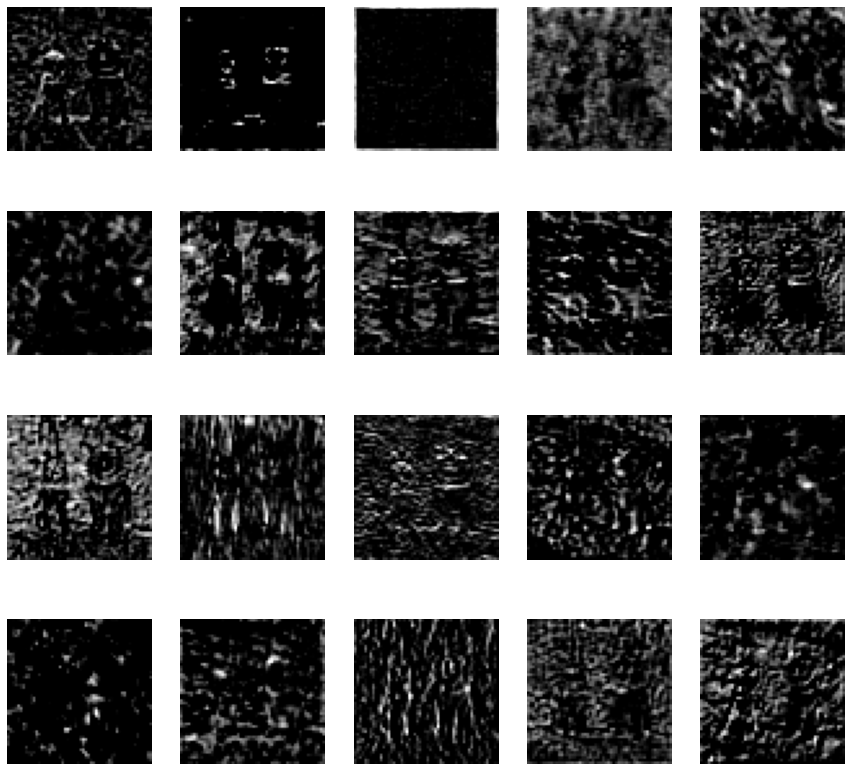

In [10]:
view_layer(model, x, "block3_conv1")

block4_conv1
shape: (1, 28, 28, 512)  min: 0.0  max: 7569.845703125


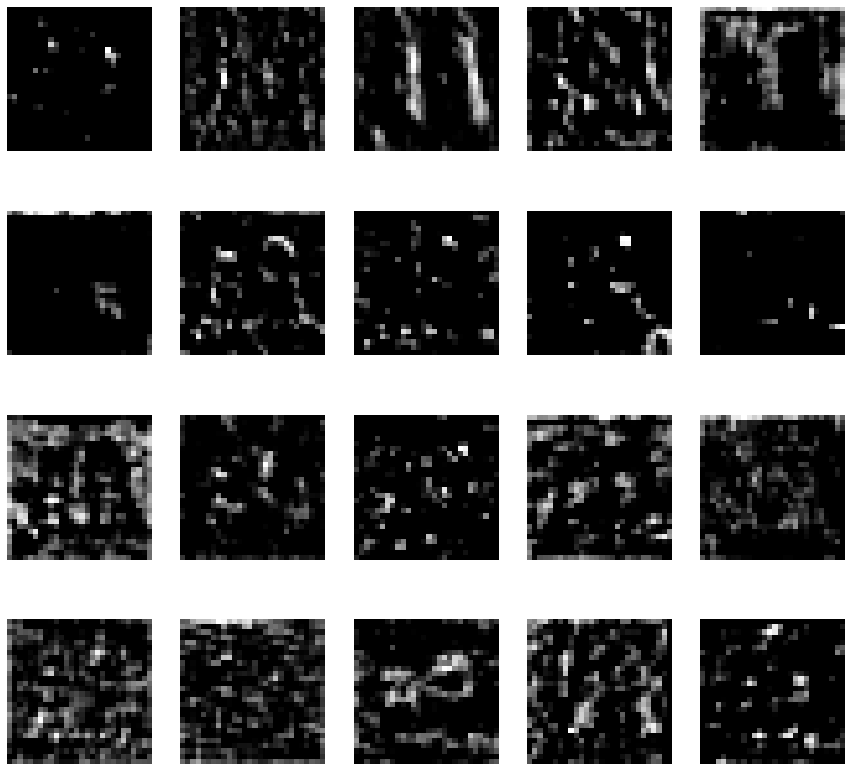

In [11]:
view_layer(model, x, "block4_conv1")

block5_conv1
shape: (1, 14, 14, 512)  min: 0.0  max: 2017.851806640625


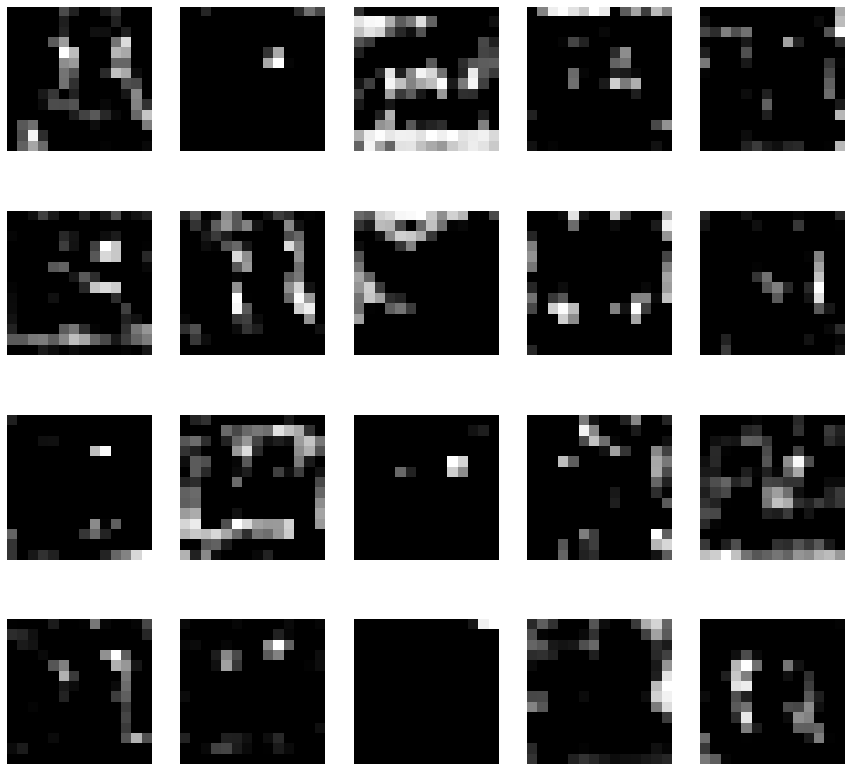

In [12]:
view_layer(model, x, "block5_conv1")

block5_conv3
shape: (1, 14, 14, 512)  min: 0.0  max: 319.8306579589844


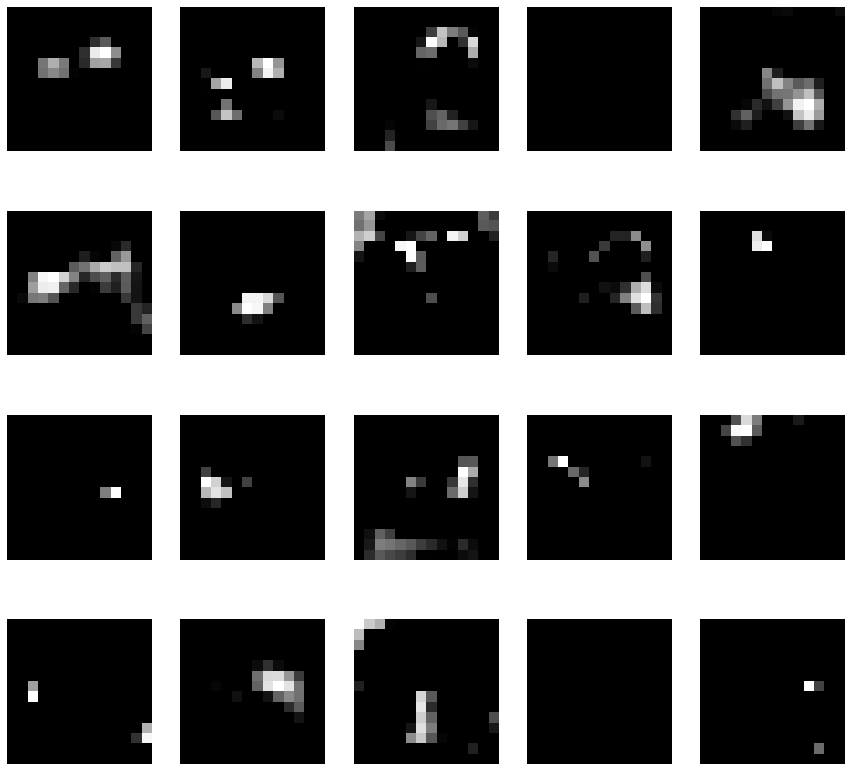

In [13]:
view_layer(model, x, "block5_conv3")

In [14]:
predictions = model.predict(x)#預測圖片

#找到最大值對應的標籤
label_index = np.argmax(predictions)
print("label index: ", label_index)

#顯示預測前三
decode_predictions(predictions,top=3)

label index:  249
40960/35363 [==================================] - 0s 0us/step


[[('n02110063', 'malamute', 0.7351754),
  ('n02110185', 'Siberian_husky', 0.17270559),
  ('n02109961', 'Eskimo_dog', 0.08778877)]]

shape: (1, 1000)  min: 2.0648188223787965e-14  max: 0.735175371170044


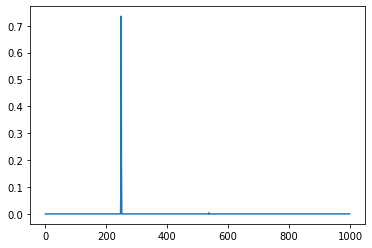

In [15]:
# 預測值長條圖
plt.plot(read_layer(model, x, "predictions"))
plt.show()

In [16]:
from google.colab.patches import cv2_imshow #cv2.imshow在Colab上不起作用，改用cv2_imshow

def Grad_CAM(orig,layer_name='block5_conv3', intensity=0.5, res=250):
  img=skimage.io.imread(orig)
  img = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_NEAREST)

  x = img.astype(np.float32)
  x = np.expand_dims(x, 0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) #印出圖片的預測

#定義一個tf.GradientTape，以便計算梯度（這是tf.2中的用法，tf.1直接用K.gradient就可以了)
  with tf.GradientTape() as tape:
    conv_layer = model.get_layer(layer_name)#最後一個卷積層
    iterate = models.Model([model.inputs], [model.output, conv_layer.output])#列表:(圖像,模型輸出&最終一個卷積層)
    model_out, conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, conv_layer)#預測輸出和最後一個捲積的梯度
    pooled_grads = K.mean(grads, axis=(0, 1, 2))#在所有軸間求平均
    #pooled_grads=w
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_layer), axis=-1)
  
  #可視化熱圖
  
  heatmap = np.maximum(heatmap, 0)#ReLU
  #normalize
  max_heat = np.max(heatmap)
  if max_heat == 0:
      max_heat = 1e-10
  heatmap /= max_heat
  heatmap=np.squeeze(heatmap)
  plt.matshow(heatmap)
  plt.show()
  

  #結合熱圖跟用來預測的圖片
  img = cv2.imread(orig)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  #im2=cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))#原圖
  im3=cv2_imshow(cv2.resize(img, (res, res)))#gradCAM圖



In [17]:
def Grad_CAM_plus(orig,layer_name='block5_conv3',intensity=0.5,res=250):
  img=skimage.io.imread(orig)
  img = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_NEAREST)

  x = img.astype(np.float32)
  x = np.expand_dims(x, 0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) #印出圖片的預測

  conv_layer = model.get_layer(layer_name)
  cam = models.Model([model.inputs], [conv_layer.output,model.output ])

  with tf.GradientTape() as gtape1:

      with tf.GradientTape() as gtape2:
        
          with tf.GradientTape() as gtape3:
            conv_layer,model_outs  = cam(x)
            class_out = model_outs[:, np.argmax(model_outs[0])]
            grad_1st = gtape3.gradient(class_out, conv_layer)
          grad_2nd = gtape2.gradient(grad_1st, conv_layer)
      grad_3rd = gtape1.gradient(grad_2nd, conv_layer)

  #alpha
  #分子
  alpha_num = grad_2nd[0]
  #分母
  global_sum = np.sum(conv_layer, axis=(0, 1, 2))
  alpha_denom =(2.0*alpha_num) + (global_sum*grad_3rd[0])
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom,1e-10)#np.where(condition,out1,out2)滿足condition輸出out1，不滿足輸出out2
  alpha = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alpha, axis=(0,1))
  alpha /= alpha_normalization_constant

  w = np.multiply(np.maximum(grad_1st[0], 0.0),alpha)
  w=np.sum(w,axis=(0,1))
  w[np.isnan(w)]=0.0
  heatmap = np.sum(w*conv_layer[0], axis=-1)
  heatmap = np.maximum(heatmap, 0)
  max_heat = np.max(heatmap)
  if max_heat == 0:
    max_heat = 1e-10
  heatmap /= max_heat
  tensor_summary(heatmap)
  plt.matshow(heatmap)

  #結合熱圖跟用來預測的圖片
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img = heatmap * intensity + img
  #show image.
  #cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))#原圖
  cv2_imshow(cv2.resize(img, (res, res)))



Siberian_husky


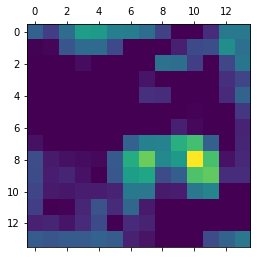

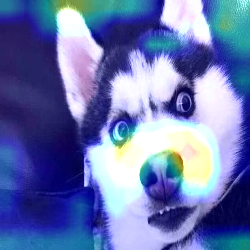

Siberian_husky
shape: (14, 14)  min: 0.00912532489746809  max: 1.0


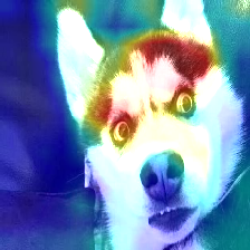

malamute


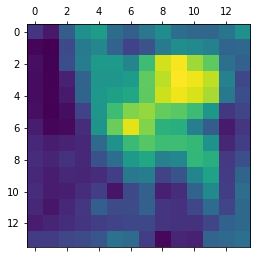

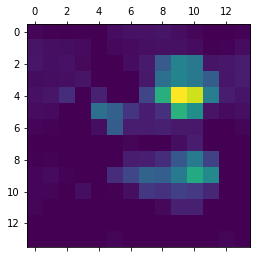

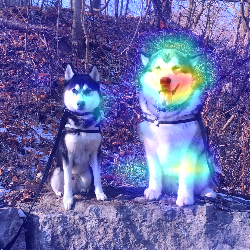

malamute
shape: (14, 14)  min: 0.0  max: 1.0


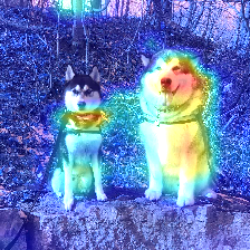

Eskimo_dog


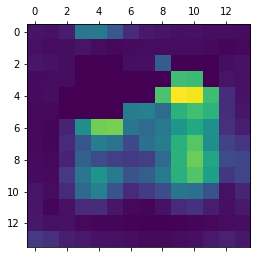

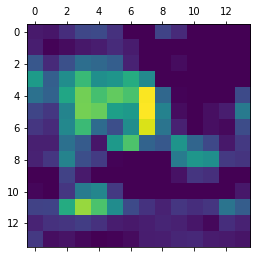

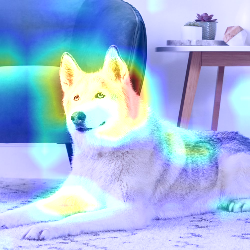

Eskimo_dog
shape: (14, 14)  min: 0.00975796114653349  max: 1.0


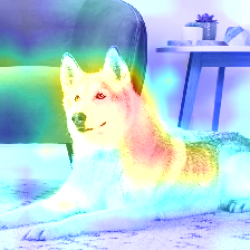

tiger


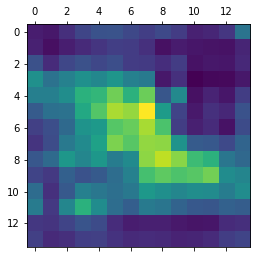

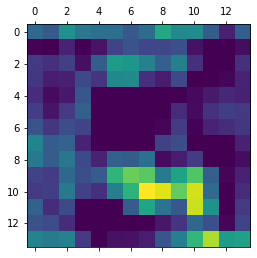

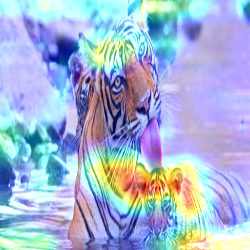

tiger
shape: (14, 14)  min: 0.0  max: 1.0


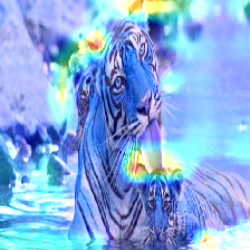

FileNotFoundError: ignored

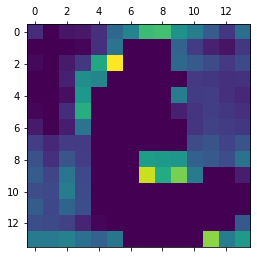

In [18]:
Grad_CAM('husky1.jpg')
Grad_CAM_plus('husky1.jpg')
Grad_CAM('husky3.jpg')
Grad_CAM_plus('husky3.jpg')
Grad_CAM('husky7.jpg')
Grad_CAM_plus('husky7.jpg')
Grad_CAM('tiger.jpg')
Grad_CAM_plus('tiger.jpg')
Grad_CAM('dog.jpg')
Grad_CAM_plus('dog.jpg')